# Mollow-triplets plots

In [1]:
from functools import partial
import pathlib
import pdb

import pickle
import numpy as np
from scipy.optimize import minimize
from scipy.fftpack import fft, rfft, fftfreq, rfftfreq, fftshift
from scipy.integrate import quad
from scipy.special import factorial
import matplotlib.pyplot as plt

import seaborn as sns

import pysme.integrate as integ
import pysme.hierarchy as hier

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# define Qubit operators
sx = np.array([[0, 1], [1, 0]], dtype=np.complex)
sy = np.array([[0, -1.j], [1.j, 0]], dtype=np.complex)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex)
Id = np.eye(2, dtype=np.complex)
sp = (sx + 1.j * sy) / 2
sm = (sx - 1.j * sy) / 2
zero = np.zeros((2, 2), dtype=np.complex)

In [4]:
plt.style.use('../paper.mplstyle')

A coherent drive adds a Hamiltonian term.
\begin{align}
    d\rho&=dt[\beta^*L-\beta L^\dagger,\rho]+dt\mathcal{D}[L]\rho \\
    &=-idt[i\beta^*L-i\beta L^\dagger,\rho]+dt\mathcal{D}[L]\rho \\
    H_{\text{eff}}&=i\beta^*L-i\beta L^\dagger
\end{align}
Rabi frequency $\Omega=2|\beta|$. Carmichæl notates the Rabi frequency as $2\Omega$, so $\Omega=|\beta|$.

In [5]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

In [6]:
def xi_rect(t, a, b):
    return rect(t, a, b)/np.sqrt(b - a)

In [7]:
def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(n):
    ket = np.zeros(n + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

def make_squeezed_state_vec(r, mu, N, normalized=True):
    r'''Make a truncated squeezed-state vector.

    The squeezed-state vector is :math:`S(r,\mu)|0\rangle`. The truncated
    vector is renormalized by default.

    Parameters
    ----------
    N: positive integer
        The dimension of the truncated Hilbert space, basis {0, ..., N-1}
    r: real number
        Squeezing amplitude
    mu: real number
        Squeezing phase
    normalized: boolean
        Whether or not the truncated vector is renormalized

    Returns
    -------
    numpy.array
        Squeezed-state vector in the truncated Hilbert space, represented in the
        number basis

    '''
    ket = np.zeros(N, dtype=np.complex)
    for n in range(N//2):
        ket[2*n] = (1 / np.sqrt(np.cosh(r))) * ((-0.5 * np.exp(2.j * mu) * np.tanh(r))**n /
                                                factorial(n)) * np.sqrt(factorial(2 * n))
    return ket / np.linalg.norm(ket) if normalized else ket

def sqz_rho(r, mu, n):
    return rho_from_ket(make_squeezed_state_vec(r, mu, n + 1))

def Heff_fn(beta, L):
    return 1.j*np.conj(beta)*L - 1.j*beta*L.conj().T

def calc_hier_state_evo(xi_fn, L, r, mu, beta, gamma, m_max, rho_ss, t, t0=0, timesteps=2**10,
                        solve_ivp_kwargs=None):
    Id_field = np.eye(m_max + 1, dtype=np.complex)
    factory = hier.HierarchyIntegratorFactory(2, m_max)
    integrator = factory.make_uncond_integrator(xi_fn, Id, np.sqrt(gamma) * L, Heff_fn(beta, L), r, mu)
    times = np.linspace(t0, t, timesteps)
    soln_t = integrator.integrate(rho_ss, times)
    return soln_t

def calc_hier_auto_corr(xi_fn, L, r, mu, beta, gamma, m_max, taus, rho_ss, t, t0=0, timesteps=2**10,
                        solve_ivp_kwargs=None):
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)
    Id_field = np.eye(m_max + 1, dtype=np.complex)
    factory = hier.HierarchyIntegratorFactory(2, m_max)
    integrator = factory.make_uncond_integrator(xi_fn, Id, np.sqrt(gamma) * L, Heff_fn(beta, L), r, mu)
    times = np.linspace(t0, t, timesteps)
    soln_t = integrator.integrate(rho_ss, times)
    sp_ss_t = soln_t.get_expectations(sp, vac_rho(m_max), idx_slice=np.s_[-1], hermitian=False)
    rho_ss_t = soln_t.get_hierarchy_density_matrices(np.s_[-1])
    L_t_t = rho_ss_t @ np.kron(sp, Id_field)
    L_t_taus = integrator.integrate_hier_init_cond(L_t_t, taus + t,
                                                   solve_ivp_kwargs=solve_ivp_kwargs)
    Expt_t_taus = L_t_taus.get_expectations(sm, vac_rho(m_max), hermitian=False)
    soln_t_taus = integrator.integrate_hier_init_cond(rho_ss_t, taus + t,
                                                      solve_ivp_kwargs=solve_ivp_kwargs)
    sm_ss_t_taus = soln_t_taus.get_expectations(sm, vac_rho(m_max), hermitian=False)
    # Subtract off a bunch of stuff that gets rid of the delta
    return (Expt_t_taus - sp_ss_t * sm_ss - sp_ss * sm_ss_t_taus + sp_ss * sm_ss,
            sp_ss, sm_ss, sp_ss_t, sm_ss_t_taus)

def calc_white_auto_corr(L, gamma, beta, r, mu, times_ss, taus, solve_ivp_kwargs=None):
    N = np.sinh(r)**2
    M_sq = -np.exp(2.j * mu) * np.sinh(r) * np.cosh(r)
    integrator = integ.UncondGaussIntegrator(np.sqrt(gamma)*L, M_sq, N, Heff_fn(beta, L))
    soln_ss = integrator.integrate(Id/2, times_ss)

    #pdb.set_trace()

    rho_ss = soln_ss.get_density_matrices(np.s_[-1])
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)

    #pdb.set_trace()

    L_0_taus = integrator.integrate_non_herm(rho_ss @ sp, taus, solve_ivp_kwargs=solve_ivp_kwargs)

    #pdb.set_trace()

    Expt_t_taus = L_0_taus.get_expectations(sm, hermitian=False)

    #pdb.set_trace()
    return rho_ss, Expt_t_taus - sp_ss * sm_ss

def calc_quasi_markoff_degen_PA_auto_corr(
        gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s, times_ss, taus, solve_ivp_kwargs=None):
    N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A = get_degen_PA_params(
        Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s)
    integrator = integ.QuasiMarkoff2LvlIntegrator(
        gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A)
    soln_ss = integrator.integrate(Id/2, times_ss)

    rho_ss = soln_ss.get_density_matrices(np.s_[-1])
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)

    L_0_taus = integrator.integrate_non_herm(rho_ss @ sp, taus, solve_ivp_kwargs=solve_ivp_kwargs)

    Expt_t_taus = L_0_taus.get_expectations(sm, hermitian=False)
    return rho_ss, Expt_t_taus - sp_ss * sm_ss

In [8]:
def calc_hier_auto_corr_fock(xi_fn, L, r, mu, beta, gamma, m_max, taus, rho_ss, t, t0=0, timesteps=2**10,
                             solve_ivp_kwargs=None):
    """Get the auto-correlation function for the Fock hierarchy
    
    Parameters
    ----------
    xi_fn:
        The wavepacket-envelope function
    L:
        The Lindblad operator
    r:
        The logarithm of the magnitude of the squeezing amplitude
    mu:
        The phase of the squeezing
    beta:
        The amplitude of the coherent drive
    gamma:
        The linewidth of the atom
    m_max:
        The maximum level of the hierarchy used
    taus:
        The time offsets for the two-time correlations
    rho_ss:
        The steady-state density matrix under the coherent drive
    t:
        The reference time for the two-time correlations
    t0:
        The initial time to start evolving the coherent-drive steady-state density matrix
        (should be when the wavepacket starts)
    timesteps:
        The number of timesteps to use for the density-matrix evolution
    """
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)
    Id_field = np.eye(m_max + 1, dtype=np.complex)
    factory = hier.HierarchyIntegratorFactory(2, m_max)
    integrator = factory.make_uncond_integrator(xi_fn, Id, np.sqrt(gamma) * L, Heff_fn(beta, L), 0, 0)
    times = np.linspace(t0, t, timesteps)
    soln_t = integrator.integrate(rho_ss, times)
    sp_ss_t = soln_t.get_expectations(sp, sqz_rho(r, mu, m_max), idx_slice=np.s_[-1], hermitian=False)
    rho_ss_t = soln_t.get_hierarchy_density_matrices(np.s_[-1])
    L_t_t = rho_ss_t @ np.kron(sp, Id_field)
    L_t_taus = integrator.integrate_hier_init_cond(L_t_t, taus + t,
                                                   solve_ivp_kwargs=solve_ivp_kwargs)
    Expt_t_taus = L_t_taus.get_expectations(sm, sqz_rho(r, mu, m_max), hermitian=False)
    soln_t_taus = integrator.integrate_hier_init_cond(rho_ss_t, taus + t,
                                                      solve_ivp_kwargs=solve_ivp_kwargs)
    sm_ss_t_taus = soln_t_taus.get_expectations(sm, sqz_rho(r, mu, m_max), hermitian=False)
    # Subtract off a bunch of stuff that gets rid of the delta
    return (Expt_t_taus - sp_ss_t * sm_ss - sp_ss * sm_ss_t_taus + sp_ss * sm_ss,
            sp_ss, sm_ss, sp_ss_t, sm_ss_t_taus)

In [9]:
def plot_emission_spectrum(auto_corr, d_tau, label, beta, plot_kwargs=None, ax=None, figsize=(10,3)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        return_fig = True
    else:
        return_fig = False
    if plot_kwargs is None:
        plot_kwargs = dict()
    fourier = fft(auto_corr.real)
    freqs = fftfreq(n=auto_corr.size, d=d_tau)
    ax.plot(fftshift(freqs), np.abs(fftshift(fourier)), label=label, **plot_kwargs)
    ax.legend()
    ax.set_xticks([-np.abs(beta) / np.pi, 0, np.abs(beta) / np.pi])
    ax.set_xlim(-1.5 * np.abs(beta) / np.pi, 1.5 * np.abs(beta) / np.pi)
    ax.set_xticklabels([r'$\omega_c-\Omega$', r'$\omega_c$', r'$\omega_c+\Omega$'])
    ax.set_yticks([])
    ax.set_ylim(0, None)
    ax.set_ylabel(r'$S(\omega)$')
    ax.set_xlabel(r'$\omega$')
    return (fig, ax) if return_fig else None

In [10]:
rho0 = (Id - sz) / 2
S = Id
L = sm
H = zero
gamma = 0.5
beta = 8.j
T = 2**8
taus = np.linspace(0, T, 2**13)

In [11]:
times_ss = np.linspace(0, 32, 2**12)
rho_ss_coh, delta_Expt_t_taus_coh = calc_white_auto_corr(L, gamma, beta, 0, 0, times_ss, taus,
                                                         solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

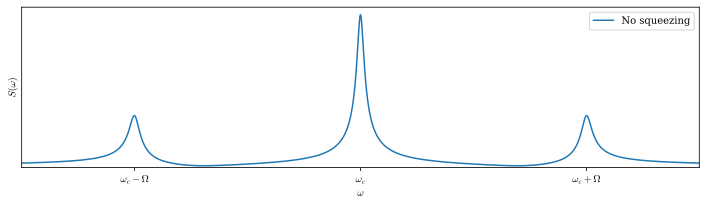

In [12]:
fig, ax = plot_emission_spectrum(
    auto_corr=delta_Expt_t_taus_coh,
    d_tau=np.diff(taus)[0],
    label='No squeezing',
    beta=beta,
)
plt.tight_layout()
plt.show()

In [13]:
def gen_save_load_data(data_gen_method, fname, overwrite=False):
    '''Get the data returned by the generating method, running the method only if the data isn't already available.

    If the given filename exists, load and return the data from that file. Otherwise generate the data using the
    supplied method and save and return it.

    Useful for notebooks you imagine running multiple times, but where some of the data is expensive to generate
    and you want to save it to disk to be reloaded for future sessions.

    '''
    try:
        with open(fname, 'xb' if not overwrite else 'wb') as f:
            data = data_gen_method()
            pickle.dump(data, f)
    except FileExistsError:
        print('Data already exist.')
        with open(fname, 'rb') as f:
            data = pickle.load(f)
    return data

In [14]:
def gen_Expt_t_taus_wavepacket_fock(L, r, mu, beta, gamma, m_max, taus, rho_ss_coh, t_final, solve_ivp_kwargs=None):
    """Looks like we are squeezing at the sideband here because of the e^(2i beta t) modulation of the wavepacket...

    Also, we're using a wavepacket of length 2.
    """
    return calc_hier_auto_corr_fock(lambda t: xi_rect(t, 0, 2)*np.exp(2.j*np.abs(beta)*t),
                                    L, r, mu, beta, gamma, m_max,
                                    taus, rho_ss_coh, t=t_final,
                                    solve_ivp_kwargs=solve_ivp_kwargs)

In [15]:
def gen_Expt_t_taus_square_wavepacket_freq_offset_fock(L, r, mu, beta, gamma, m_max, taus, rho_ss_coh, t_final, wavepacket_length, freq_offset=0., solve_ivp_kwargs=None):
    xi_fn = lambda t: xi_rect(t, 0, wavepacket_length) * np.exp(-1.j * freq_offset * t)
    return calc_hier_auto_corr_fock(xi_fn,
                                    L, r, mu, beta, gamma, m_max,
                                    taus, rho_ss_coh, t=t_final,
                                    solve_ivp_kwargs=solve_ivp_kwargs)

In [16]:
mollow_triplet_plot_dir = pathlib.Path('mollow-triplit-plot')
if not mollow_triplet_plot_dir.exists():
    mollow_triplet_plot_dir.mkdir()

In [17]:
%%time
r = np.log(2)
mu = 0
m_max = 12
t_final = 0.5
Expt_t_taus_wavepacket_fock = gen_save_load_data(
    partial(
        gen_Expt_t_taus_wavepacket_fock,
        L=L,
        r=r,
        mu=mu,
        beta=beta,
        gamma=gamma,
        m_max=m_max,
        taus=taus,
        rho_ss_coh=rho_ss_coh,
        t_final=t_final,
        solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9}
    ),
    mollow_triplet_plot_dir.joinpath(f'er_{np.exp(r):.2f}_mu_{mu / np.pi:.2f}pi_mmax_{m_max}_tfinal_{t_final:.2f}.pickle'),
    overwrite=False,
)

Data already exist.
CPU times: user 1.01 ms, sys: 49 µs, total: 1.05 ms
Wall time: 3.72 ms


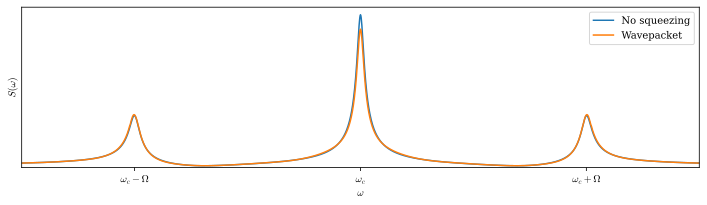

In [18]:
fig, ax = plot_emission_spectrum(
    auto_corr=delta_Expt_t_taus_coh,
    d_tau=np.diff(taus)[0],
    label='No squeezing',
    beta=beta,
)
plot_emission_spectrum(
    auto_corr=Expt_t_taus_wavepacket_fock[0],
    d_tau=np.diff(taus)[0],
    label='Wavepacket',
    beta=beta,
    ax=ax,
)
plt.tight_layout()

The squeezing used in my dissertation (as extracted from my `2018-06-12-2` notebook, which generated the data I plotted for my dissertation in my `2018-06-13` notebook) is $r=\ln4$

```python
Expt_t_taus['Resonant'] = {'data': Expt_t_taus_wavepacket_on_res[0],
                           'gamma': 0.5,
                           'beta': 8.j,
                           'r': np.log(4),
                           'mu': 0,
                           'xi freq': 0,
                           'm_max': 12,
                           't': 0.5,
                           'T': 2**8,
                           'N taus': 2**13}
```

```python
Expt_t_taus['Resonant Phased'] = {'data': Expt_t_taus_wavepacket_on_res_phase[0],
                           'gamma': 0.5,
                           'beta': 8.j,
                           'r': np.log(4),
                           'mu': np.pi / 2,
                           'xi freq': 0,
                           'm_max': 12,
                           't': 0.5,
                           'T': 2**8,
                           'N taus': 2**13}
```

```python
Expt_t_taus['Sideband'] = {'data': Expt_t_taus_wavepacket[0],
                           'gamma': 0.5,
                           'beta': 8.j,
                           'r': np.log(4),
                           'mu': 0,
                           'xi freq': 2 * np.abs(8.j),
                           'm_max': 12,
                           't': 0.5,
                           'T': 2**8,
                           'N taus': 2**13}
```

```python
Expt_t_taus['Sideband Phased'] = {'data': Expt_t_taus_wavepacket_phase[0],
                                  'gamma': 0.5,
                                  'beta': 8.j,
                                  'r': np.log(4),
                                  'mu': np.pi / 2,
                                  'xi freq': 2 * np.abs(8.j),
                                  'm_max': 12,
                           't': 0.5,
                                  'T': 2**8,
                                  'N taus': 2**13}
```

In [19]:
def gen_save_load_data_with_args(fname, data_gen_method, method_args=None, method_kwargs=None, overwrite=False):
    '''Get the data returned by the generating method, running the method only if the data isn't already available.

    If the given filename exists, load and return the data from that file. Otherwise generate the data using the
    supplied method and save and return it.

    Useful for notebooks you imagine running multiple times, but where some of the data is expensive to generate
    and you want to save it to disk to be reloaded for future sessions.

    '''
    if method_args is None:
        method_args = []
    if method_kwargs is None:
        methd_kwargs = dict()
    try:
        with open(fname, 'xb' if not overwrite else 'wb') as f:
            data = data_gen_method(*method_args, **method_kwargs)
            pickle.dump(data, f)
    except FileExistsError:
        print('Data already exist.')
        with open(fname, 'rb') as f:
            data = pickle.load(f)
    return data

In [20]:
Expt_t_taus = dict()

```python
Expt_t_taus['Resonant'] = {'data': Expt_t_taus_wavepacket_on_res[0],
                           'gamma': 0.5,
                           'beta': 8.j,
                           'r': np.log(4),
                           'mu': 0,
                           'xi freq': 0,
                           'm_max': 12,
                           't': 0.5,
                           'T': 2**8,
                           'N taus': 2**13}
```

In [21]:
%%time
r = np.log(4)
mu = 0
freq_offset = 0.
m_max = 20
t_final = 0.5
wavepacket_length = 4 * gamma

Expt_t_taus['Resonant'] = gen_save_load_data_with_args(
    fname=mollow_triplet_plot_dir.joinpath(f'er_{np.exp(r):.2f}_mu_{mu / np.pi:.2f}pi_mmax_{m_max}_tfinal_{t_final:.2f}.pickle'),
    data_gen_method=gen_Expt_t_taus_square_wavepacket_freq_offset_fock,
    method_kwargs=dict(
        L=L,
        r=r,
        mu=mu,
        beta=beta,
        gamma=gamma,
        m_max=m_max,
        taus=taus,
        rho_ss_coh=rho_ss_coh,
        t_final=t_final,
        freq_offset=freq_offset,
        wavepacket_length=wavepacket_length,
        solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9},
    ),
    overwrite=False,
)

Data already exist.
CPU times: user 1.3 ms, sys: 62 µs, total: 1.36 ms
Wall time: 2.84 ms


In [22]:
mollow_triplet_plot_dir.joinpath(f'er_{np.exp(r):.2f}_mu_{mu / np.pi:.2f}pi_mmax_{m_max}_tfinal_{t_final:.2f}.pickle')

PosixPath('mollow-triplit-plot/er_4.00_mu_0.00pi_mmax_20_tfinal_0.50.pickle')

```python
Expt_t_taus['Resonant Phased'] = {'data': Expt_t_taus_wavepacket_on_res_phase[0],
                           'gamma': 0.5,
                           'beta': 8.j,
                           'r': np.log(4),
                           'mu': np.pi / 2,
                           'xi freq': 0,
                           'm_max': 12,
                           't': 0.5,
                           'T': 2**8,
                           'N taus': 2**13}
```

In [23]:
%%time
gamma = 0.5
beta = 8.j
r = np.log(4)
mu = np.pi / 2
freq_offset = 0.
m_max = 20
t_final = 0.5
taus = np.linspace(0, 2**8, 2**13)
wavepacket_length = 4 * gamma

Expt_t_taus['Resonant Phased'] = gen_save_load_data_with_args(
    fname=mollow_triplet_plot_dir.joinpath(f'er_{np.exp(r):.2f}_mu_{mu / np.pi:.2f}pi_mmax_{m_max}_tfinal_{t_final:.2f}.pickle'),
    data_gen_method=gen_Expt_t_taus_square_wavepacket_freq_offset_fock,
    method_kwargs=dict(
        L=L,
        r=r,
        mu=mu,
        beta=beta,
        gamma=gamma,
        m_max=m_max,
        taus=taus,
        rho_ss_coh=rho_ss_coh,
        t_final=t_final,
        freq_offset=freq_offset,
        wavepacket_length=wavepacket_length,
        solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9},
    ),
    overwrite=False,
)

Data already exist.
CPU times: user 1.52 ms, sys: 0 ns, total: 1.52 ms
Wall time: 2.96 ms


```python
Expt_t_taus['Sideband'] = {'data': Expt_t_taus_wavepacket[0],
                           'gamma': 0.5,
                           'beta': 8.j,
                           'r': np.log(4),
                           'mu': 0,
                           'xi freq': 2 * np.abs(8.j),
                           'm_max': 12,
                           't': 0.5,
                           'T': 2**8,
                           'N taus': 2**13}
```

In [24]:
%%time
gamma = 0.5
beta = 8.j
r = np.log(4)
mu = 0.
freq_offset = 2 * np.abs(beta)
m_max = 20
t_final = 0.5
taus = np.linspace(0, 2**8, 2**13)
wavepacket_length = 4 * gamma

Expt_t_taus['Sideband'] = gen_save_load_data_with_args(
    fname=mollow_triplet_plot_dir.joinpath(f'er_{np.exp(r):.2f}_mu_{mu / np.pi:.2f}pi_mmax_{m_max}_tfinal_{t_final:.2f}_freq_offset_{freq_offset:.2f}.pickle'),
    data_gen_method=gen_Expt_t_taus_square_wavepacket_freq_offset_fock,
    method_kwargs=dict(
        L=L,
        r=r,
        mu=mu,
        beta=beta,
        gamma=gamma,
        m_max=m_max,
        taus=taus,
        rho_ss_coh=rho_ss_coh,
        t_final=t_final,
        freq_offset=freq_offset,
        wavepacket_length=wavepacket_length,
        solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9},
    ),
    overwrite=False,
)

Data already exist.
CPU times: user 1.26 ms, sys: 60 µs, total: 1.32 ms
Wall time: 2.64 ms


```python
Expt_t_taus['Sideband Phased'] = {'data': Expt_t_taus_wavepacket_phase[0],
                                  'gamma': 0.5,
                                  'beta': 8.j,
                                  'r': np.log(4),
                                  'mu': np.pi / 2,
                                  'xi freq': 2 * np.abs(8.j),
                                  'm_max': 12,
                           't': 0.5,
                                  'T': 2**8,
                                  'N taus': 2**13}
```

In [25]:
%%time
gamma = 0.5
beta = 8.j
r = np.log(4)
mu = np.pi / 2
freq_offset = 2 * np.abs(beta)
m_max = 20
t_final = 0.5
taus = np.linspace(0, 2**8, 2**13)
wavepacket_length = 4 * gamma

Expt_t_taus['Sideband Phased'] = gen_save_load_data_with_args(
    fname=mollow_triplet_plot_dir.joinpath(f'er_{np.exp(r):.2f}_mu_{mu / np.pi:.2f}pi_mmax_{m_max}_tfinal_{t_final:.2f}_freq_offset_{freq_offset:.2f}.pickle'),
    data_gen_method=gen_Expt_t_taus_square_wavepacket_freq_offset_fock,
    method_kwargs=dict(
        L=L,
        r=r,
        mu=mu,
        beta=beta,
        gamma=gamma,
        m_max=m_max,
        taus=taus,
        rho_ss_coh=rho_ss_coh,
        t_final=t_final,
        freq_offset=freq_offset,
        wavepacket_length=wavepacket_length,
        solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9},
    ),
    overwrite=False,
)

Data already exist.
CPU times: user 1.6 ms, sys: 0 ns, total: 1.6 ms
Wall time: 2.97 ms


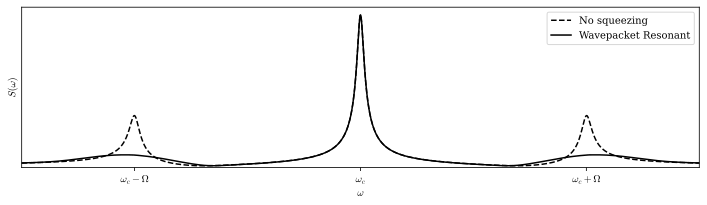

In [26]:
fig, ax = plot_emission_spectrum(
    auto_corr=delta_Expt_t_taus_coh,
    label='No squeezing',
    d_tau=np.diff(taus)[0],
    beta=beta,
    plot_kwargs=dict(
        color='k',
        linestyle='--',
    ),
)
plot_emission_spectrum(
    auto_corr=Expt_t_taus['Resonant'][0],
    label='Wavepacket Resonant',
    d_tau=np.diff(taus)[0],
    beta=beta,
    ax=ax,
    plot_kwargs=dict(
        color='k',
    ),
)
plt.tight_layout()
plt.show()

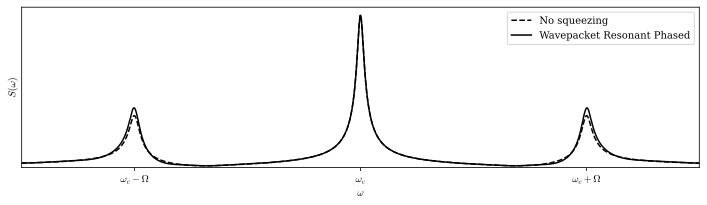

In [27]:
fig, ax = plot_emission_spectrum(
    auto_corr=delta_Expt_t_taus_coh,
    label='No squeezing',
    d_tau=np.diff(taus)[0],
    beta=beta,
    plot_kwargs=dict(
        color='k',
        linestyle='--',
    ),
)
plot_emission_spectrum(
    auto_corr=Expt_t_taus['Resonant Phased'][0],
    label='Wavepacket Resonant Phased',
    d_tau=np.diff(taus)[0],
    beta=beta,
    ax=ax,
    plot_kwargs=dict(
        color='k',
    ),
)
plt.tight_layout()
plt.show()

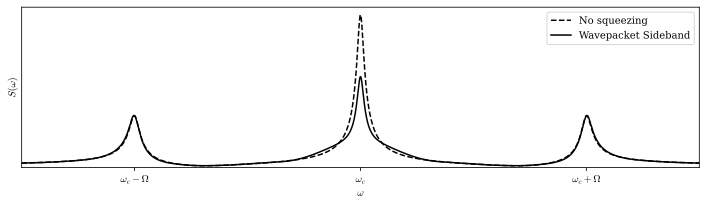

In [28]:
fig, ax = plot_emission_spectrum(
    auto_corr=delta_Expt_t_taus_coh,
    label='No squeezing',
    d_tau=np.diff(taus)[0],
    beta=beta,
    plot_kwargs=dict(
        color='k',
        linestyle='--',
    ),
)
plot_emission_spectrum(
    auto_corr=Expt_t_taus['Sideband'][0],
    label='Wavepacket Sideband',
    d_tau=np.diff(taus)[0],
    beta=beta,
    ax=ax,
    plot_kwargs=dict(
        color='k',
    ),
)
plt.tight_layout()
plt.show()

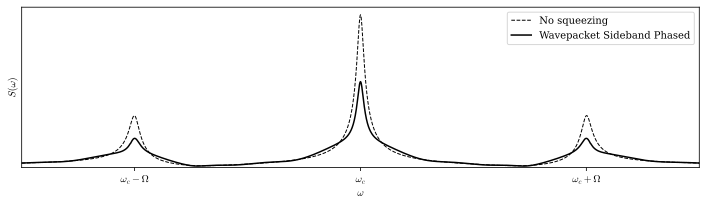

In [29]:
fig, ax = plot_emission_spectrum(
    auto_corr=delta_Expt_t_taus_coh,
    label='No squeezing',
    d_tau=np.diff(taus)[0],
    beta=beta,
    plot_kwargs=dict(
        color='k',
        linestyle='--',
        linewidth=1,
    ),
)
plot_emission_spectrum(
    auto_corr=Expt_t_taus['Sideband Phased'][0],
    label='Wavepacket Sideband Phased',
    d_tau=np.diff(taus)[0],
    beta=beta,
    ax=ax,
    plot_kwargs=dict(
        color='k',
    ),
)
plt.tight_layout()
plt.savefig('sideband-phased.png', dpi=150)
plt.show()

In [30]:
SINGLE_COL_WIDTH = 3.4039 #INCHES
DOUBLE_COL_WIDTH = 7.0569 #INCHES 

SMALL_SIZE = 6.5
MEDIUM_SIZE = 8.5
BIGGER_SIZE = 10.5

plt.rc('text', usetex=False)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines',linewidth=0.75)
#plt.rcParams['ytick.major.pad']='0.5'

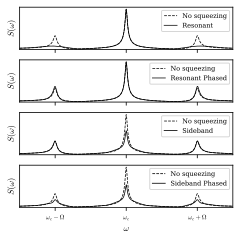

In [31]:
fig, axs = plt.subplots(nrows=4, ncols=1, sharex='col', figsize=(SINGLE_COL_WIDTH, SINGLE_COL_WIDTH))
for ax, expt_t_taus_key in zip(axs, ['Resonant', 'Resonant Phased', 'Sideband', 'Sideband Phased']):
    plot_emission_spectrum(
        auto_corr=delta_Expt_t_taus_coh,
        label='No squeezing',
        d_tau=np.diff(taus)[0],
        beta=beta,
        ax=ax,
        plot_kwargs=dict(
            color='k',
            linestyle='--',
        ),
    )
    plot_emission_spectrum(
        auto_corr=Expt_t_taus[expt_t_taus_key][0],
        label=expt_t_taus_key,
        d_tau=np.diff(taus)[0],
        beta=beta,
        ax=ax,
        plot_kwargs=dict(
            color='k',
        ),
    )
for ax in axs[:-1]:
    ax.set_xlabel('')
plt.tight_layout()
plt.savefig(mollow_triplet_plot_dir.joinpath('reproduced-thesis-plots.pdf'))
plt.show()

In [69]:
mpl.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

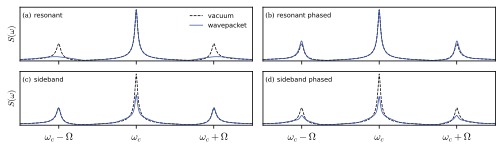

In [71]:
from itertools import chain

mpl.rcParams['xtick.labelsize'] = 10

expt_t_taus_keys = ['Resonant', 'Resonant Phased', 'Sideband', 'Sideband Phased']
fig, axs = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(DOUBLE_COL_WIDTH, 5 * SINGLE_COL_WIDTH / 8))
flat_axs = list(chain(*axs))
for ax, expt_t_taus_key, fig_label in zip(flat_axs, expt_t_taus_keys, 'abcd'):
    plot_emission_spectrum(
        auto_corr=delta_Expt_t_taus_coh,
        label='vacuum',
        d_tau=np.diff(taus)[0],
        beta=beta,
        ax=ax,
        plot_kwargs=dict(
            color='k',
            linestyle='--',
        ),
    )
    plot_emission_spectrum(
        auto_corr=Expt_t_taus[expt_t_taus_key][0],
        label='wavepacket',
        d_tau=np.diff(taus)[0],
        beta=beta,
        ax=ax,
        plot_kwargs=dict(
            color='#3852AC',
        ),
    )
    ax.get_legend().remove()
    ax.text(0.01, 0.81, f'({fig_label})', transform=ax.transAxes, family='serif')
    ax.text(0.06, 0.81, expt_t_taus_key.lower(), transform=ax.transAxes, family='sans')
axs[0][0].legend(frameon=False, prop=dict(family='sans'))
for ax in flat_axs:
    ax.set_xlabel('')
for ax_row in axs:
    ax_row[-1].set_ylabel('')
plt.tight_layout()
plt.savefig(mollow_triplet_plot_dir.joinpath('two-column-reproduced-thesis-plots.pdf'))
plt.show()